In [1]:
import torch
from torch import nn, optim
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
import glob
import MDAnalysis as mda
import itertools
from skorch import NeuralNetClassifier, NeuralNetRegressor
import pickle

In [2]:
with open('data_dict.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)


system1, system2, system3 = "popc", "sdpc", "chol-site-3"

x = np.concatenate([v for k, v in data_dict.items() if k == system1 or k == system2 or k == system3])
y = np.concatenate([[0 for i in range(data_dict[system1].shape[0])], [1 for i in range(data_dict[system2].shape[0])], [2 for i in range(data_dict[system2].shape[0])]])

Y = []

for i in range(len(data_dict.values())):
    for _ in range(list(data_dict.values())[i].shape[0]):
        Y.append(i)
        
Y = torch.Tensor(Y)
X = torch.Tensor(np.concatenate([v for v in data_dict.values()]))
x = torch.Tensor(x)
y = torch.Tensor(y)


scaler1 = StandardScaler()
scaler2 = StandardScaler()

scaler1.fit(X)
X = torch.Tensor(scaler1.transform(X))
scaler2.fit(x)
x = torch.Tensor(scaler2.transform(x))


In [3]:

def construct_encoder(input_dim, encoding_dim, dimensions_list, activation):
    
    encoder_layers = [nn.Linear(input_dim, dimensions_list[0]), activation, nn.Dropout(0.2)]
    decoder_layers = [nn.Linear(encoding_dim, dimensions_list[-1]), activation, nn.Dropout(0.2)]

    for i in range(len(dimensions_list) - 1):
        encoder_layers.append(nn.Linear(dimensions_list[i], dimensions_list[i+1]))
        encoder_layers.append(activation)
        encoder_layers.append(nn.Dropout(0.2))
        decoder_layers.append(nn.Linear(dimensions_list[::-1][i], dimensions_list[::-1][i+1]))
        decoder_layers.append(activation)
        decoder_layers.append(nn.Dropout(0.2))
        
    encoder_layers.append(nn.Linear(dimensions_list[-1], encoding_dim))
    decoder_layers.append(nn.Linear(dimensions_list[0], input_dim))

    encoder = nn.Sequential(*encoder_layers)
    decoder = nn.Sequential(*decoder_layers)
    
    class Autoencoder(nn.Module):

        def __init__(self, encoder, decoder):
            super(Autoencoder, self).__init__()
            self.encode = encoder
            self.decode = decoder
            
        def forward(self, x):
            x = self.encode(x)
            x = self.decode(x)
            return x

    return Autoencoder(encoder=encoder, decoder=decoder)



In [15]:

def train(encoder, loss_function, optimizer, n_epochs, batch_size, X):
    
    encoder.train()
    indices = [i for i in range(X.shape[0])]
    
    for epoch in range(1, n_epochs + 1):
        
        random.shuffle(indices)
        batches = [i for i in range(0, len(indices), batch_size)]

        for i in range(len(batches) - 1):
            
            batch_X = X[indices[batches[i]:batches[i+1]]]
            optimizer.zero_grad()
            output = encoder(batch_X)
            loss = loss_function(output, batch_X)
            loss.backward()
            optimizer.step()
        
        print(f"epoch {epoch} \t Loss: {loss.item():.4g}")
    #print(f"epoch {epoch} \t Loss: {loss.item():.4g}")
    

In [16]:

AE = construct_encoder(X.shape[1], 3, [512 for i in range(4)], nn.ReLU())
loss_fn = nn.MSELoss()
optimizer = optim.Adam(AE.parameters(), lr=1e-3)

train(AE, loss_fn, optimizer, 50, 128, x)


epoch 1 	 Loss: 0.6098
epoch 2 	 Loss: 0.4996
epoch 3 	 Loss: 0.3945
epoch 4 	 Loss: 0.423
epoch 5 	 Loss: 0.3659
epoch 6 	 Loss: 0.3365
epoch 7 	 Loss: 0.3393
epoch 8 	 Loss: 0.3382
epoch 9 	 Loss: 0.2824
epoch 10 	 Loss: 0.3104
epoch 11 	 Loss: 0.3189
epoch 12 	 Loss: 0.3067
epoch 13 	 Loss: 0.3064
epoch 14 	 Loss: 0.2983
epoch 15 	 Loss: 0.3093
epoch 16 	 Loss: 0.2652
epoch 17 	 Loss: 0.2781
epoch 18 	 Loss: 0.2707
epoch 19 	 Loss: 0.2548
epoch 20 	 Loss: 0.2613
epoch 21 	 Loss: 0.2611
epoch 22 	 Loss: 0.2872
epoch 23 	 Loss: 0.2533
epoch 24 	 Loss: 0.2692
epoch 25 	 Loss: 0.2633
epoch 26 	 Loss: 0.2664
epoch 27 	 Loss: 0.2658
epoch 28 	 Loss: 0.2664
epoch 29 	 Loss: 0.27
epoch 30 	 Loss: 0.245
epoch 31 	 Loss: 0.2485
epoch 32 	 Loss: 0.2552
epoch 33 	 Loss: 0.2518
epoch 34 	 Loss: 0.2453
epoch 35 	 Loss: 0.24
epoch 36 	 Loss: 0.2283
epoch 37 	 Loss: 0.2659
epoch 38 	 Loss: 0.268
epoch 39 	 Loss: 0.257
epoch 40 	 Loss: 0.2332
epoch 41 	 Loss: 0.2293
epoch 42 	 Loss: 0.2491
epoch 43 

In [6]:
with torch.no_grad():
    encoded = AE.encode(x)
    decoded = AE.decode(encoded)
    err = loss_fn(decoded, x).item()
    print(f"Error on test set: {err}")
    E = decoded - x
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

Error on test set: 0.2589285671710968


In [7]:
dec_orig = scaler2.inverse_transform(dec)

In [8]:
orig_error = np.mean((dec_orig - scaler2.inverse_transform(x))**2)

In [9]:
print(f"MSE in original space: {orig_error}")

MSE in original space: 2.869875267440908


In [10]:
z = AE.encode(x).detach().numpy()

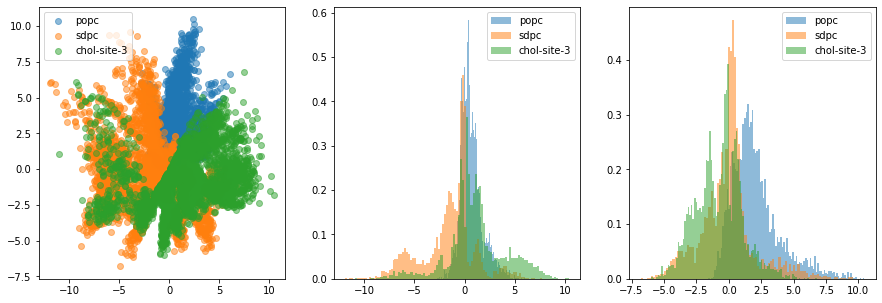

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
for i in [0, 1, 2]:
    ids = np.where(y == i)[0]
    l = [system1, system2, system3][i]
    ax[0].scatter(z[ids,0], z[ids,1], label=l, alpha=0.5)
    ax[1].hist(z[ids,0], bins=100, alpha=0.5, label=l, density=True)
    ax[2].hist(z[ids,1], bins=100, alpha=0.5, label=l, density=True)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

dim: 256, layers: 1
epoch 10 	 Loss: 0.535
Error on test set: 0.5538482069969177
MSE in original space: 5.847193914205565


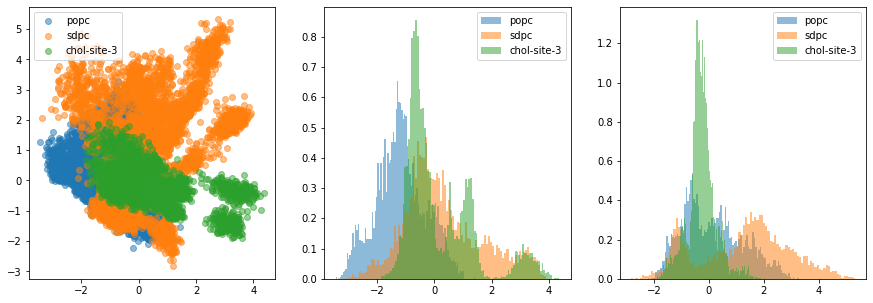

dim: 256, layers: 2
epoch 10 	 Loss: 0.4019
Error on test set: 0.3936901390552521
MSE in original space: 4.352809868144962


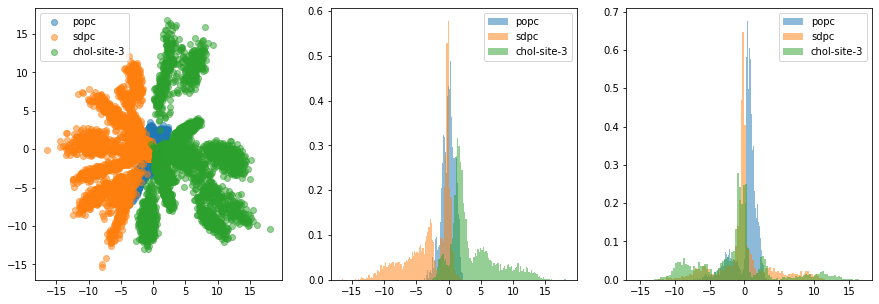

dim: 256, layers: 3
epoch 10 	 Loss: 0.3971
Error on test set: 0.393857479095459
MSE in original space: 4.4269173155984385


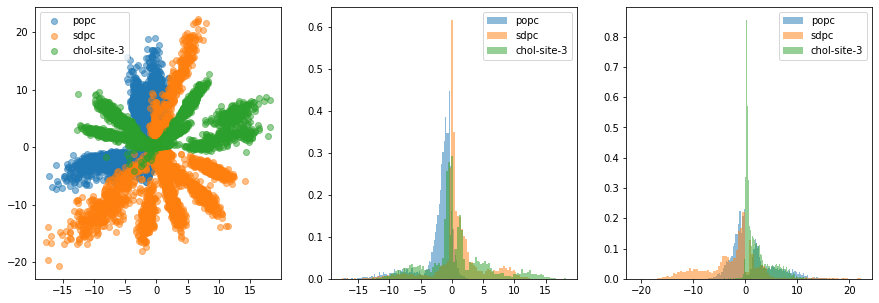

dim: 256, layers: 4
epoch 10 	 Loss: 0.4492
Error on test set: 0.4548473656177521
MSE in original space: 4.942134810503719


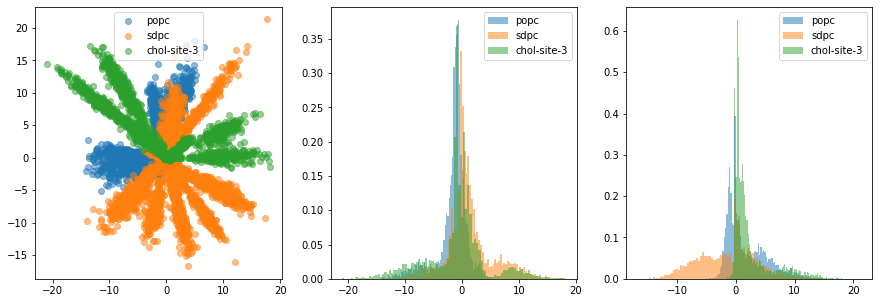

dim: 512, layers: 1
epoch 10 	 Loss: 0.505
Error on test set: 0.5205684304237366
MSE in original space: 5.507714364271715


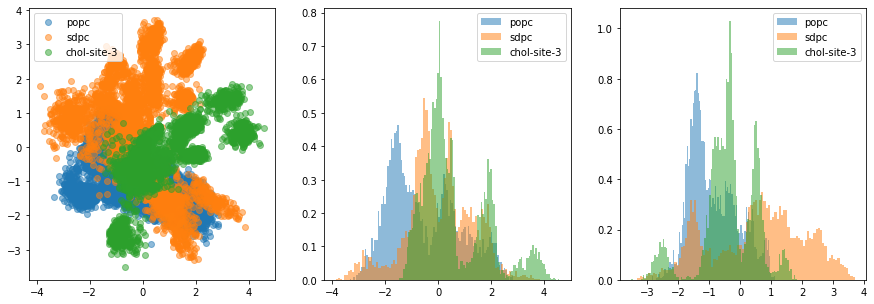

dim: 512, layers: 2
epoch 10 	 Loss: 0.3732
Error on test set: 0.35980549454689026
MSE in original space: 4.010003058335587


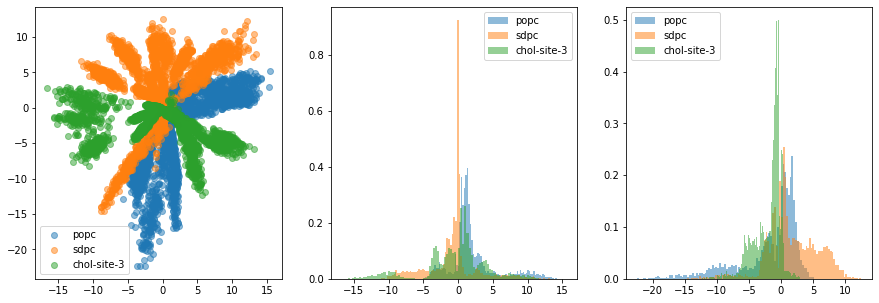

dim: 512, layers: 3
epoch 10 	 Loss: 0.3834
Error on test set: 0.36013293266296387
MSE in original space: 4.010020735074084


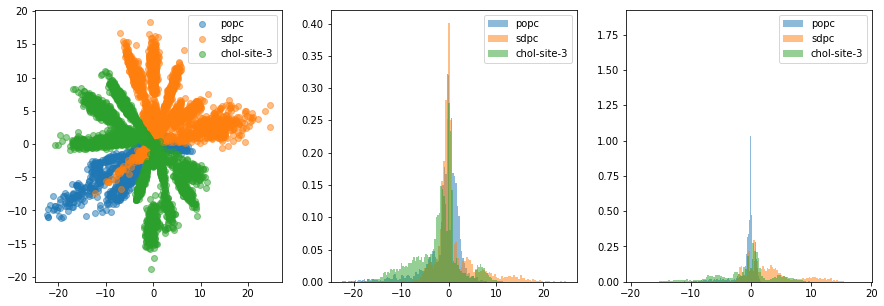

dim: 512, layers: 4
epoch 10 	 Loss: 0.4305
Error on test set: 0.3882356882095337
MSE in original space: 4.332096220371289


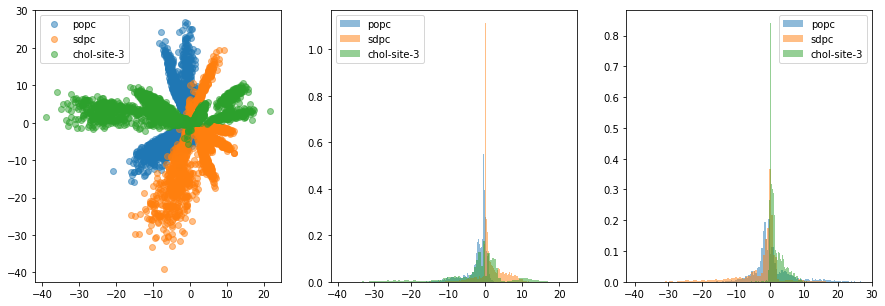

dim: 1024, layers: 1
epoch 10 	 Loss: 0.4844
Error on test set: 0.49915584921836853
MSE in original space: 5.284576883948169


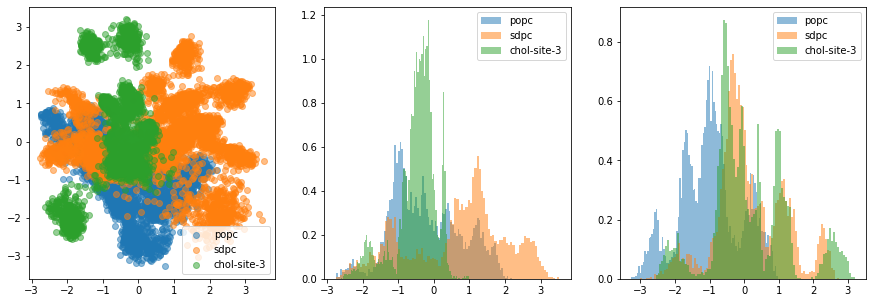

dim: 1024, layers: 2
epoch 10 	 Loss: 0.3771
Error on test set: 0.331769198179245
MSE in original space: 3.7559428012039957


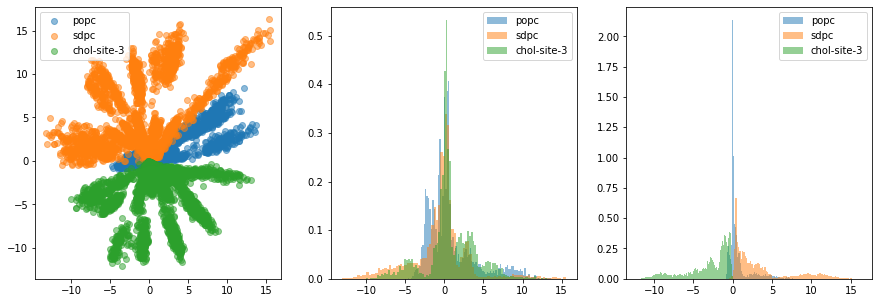

dim: 1024, layers: 3
epoch 10 	 Loss: 0.3288
Error on test set: 0.3424936532974243
MSE in original space: 3.821678079515921


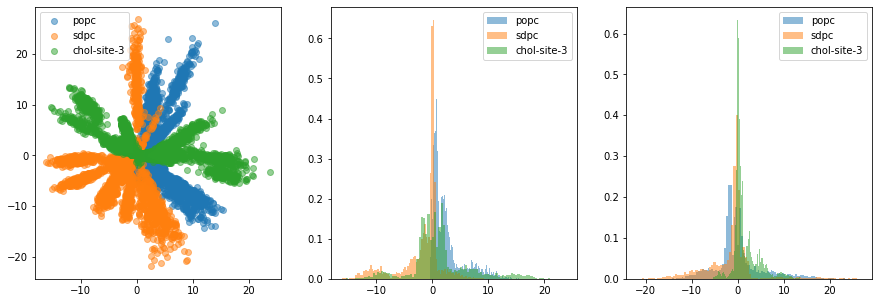

dim: 1024, layers: 4
epoch 10 	 Loss: 0.4637
Error on test set: 0.4047435224056244
MSE in original space: 4.5463094957939925


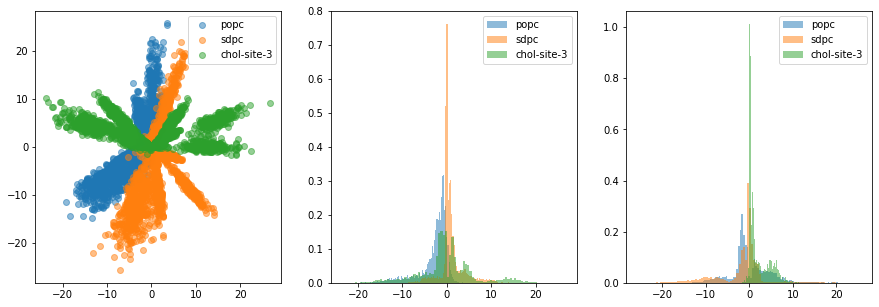

dim: 2048, layers: 1
epoch 10 	 Loss: 0.522
Error on test set: 0.48890620470046997
MSE in original space: 5.308244749196728


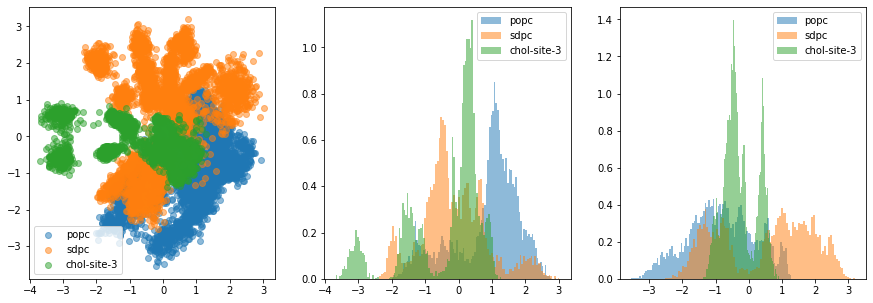

dim: 2048, layers: 2
epoch 10 	 Loss: 0.3474
Error on test set: 0.36919376254081726
MSE in original space: 4.105160121575062


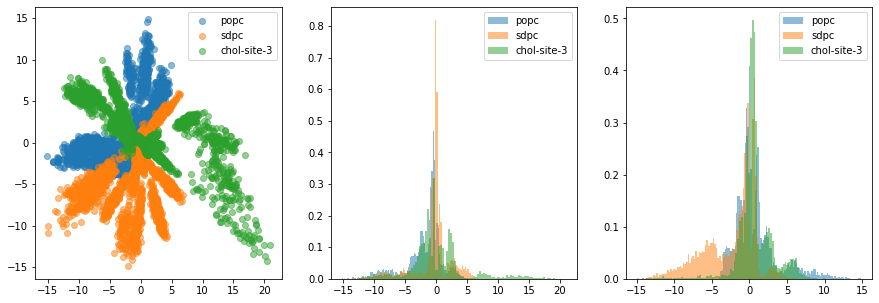

dim: 2048, layers: 3
epoch 10 	 Loss: 0.3851
Error on test set: 0.37746238708496094
MSE in original space: 4.291682429838882


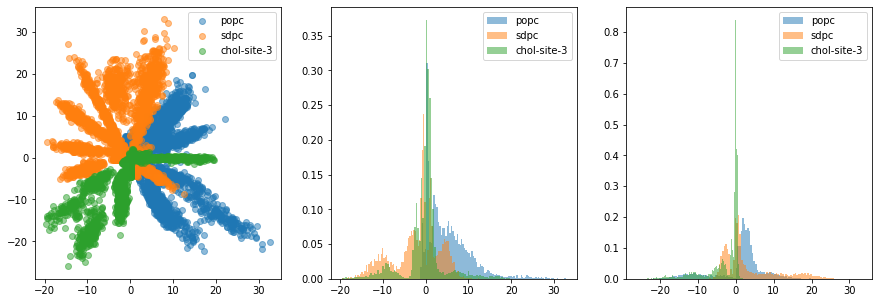

dim: 2048, layers: 4


In [14]:
for dim in [256, 512, 1024, 2048]:
    for n in range(1, 5):
        print(f"dim: {dim}, layers: {n}")
        AE = construct_encoder(X.shape[1], 2, [dim for i in range(n)], nn.ReLU())
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(AE.parameters(), lr=1e-3)

        train(AE, loss_fn, optimizer, 10, 128, x)
        
        with torch.no_grad():
            encoded = AE.encode(x)
            decoded = AE.decode(encoded)
            err = loss_fn(decoded, x).item()
            print(f"Error on test set: {err}")
            E = decoded - x
            enc = encoded.cpu().detach().numpy()
            dec = decoded.cpu().detach().numpy()
            
        dec_orig = scaler2.inverse_transform(dec)
        orig_error = np.mean((dec_orig - scaler2.inverse_transform(x))**2)
        print(f"MSE in original space: {orig_error}")
        
        z = AE.encode(x).detach().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        for i in [0, 1, 2]:
            ids = np.where(y == i)[0]
            l = [system1, system2, system3][i]
            ax[0].scatter(z[ids,0], z[ids,1], label=l, alpha=0.5)
            ax[1].hist(z[ids,0], bins=100, alpha=0.5, label=l, density=True)
            ax[2].hist(z[ids,1], bins=100, alpha=0.5, label=l, density=True)
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        plt.show()